In [1]:
from datasets import load_dataset, Dataset
from IPython.display import display
from PIL import Image
import numpy as np
import pandas as pd
import pycountry
from pprint import pprint
from typing import Callable, Tuple
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from mpl_toolkits.mplot3d import Axes3D  # This import registers the 3D projection

# Model imports
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def alpha2_to_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return None

In [5]:
def label_filter(datasets: Tuple[Dataset]) -> Tuple[Dataset]:
    # Remove labels from the dataset.
    np.random.seed(42)
    label_white_list = np.random.randint(0, 211, size=20)
    
    print("Label white list indices:", label_white_list)
    
    def keep_samples_by_label(sample):
        return sample["label"] in label_white_list

    datasets_filtered = tuple(dataset.filter(keep_samples_by_label) for dataset in datasets)
    

## Part 1 - Loading Data and exploring it

#### We will apply to only 5 countries in the reserach for easier analysis, faster training times and specified answers
Israel, USA, Japan, Nigeria, Denmark 


In [15]:
# Exploration and pre-processing functions and parameters

SELECTED_COUNTRIES = ['IL','US','JP','NG','DE']

def count_labels(label_list: list | np.ndarray) -> dict:
    """
    Counts the labels of the datasets in order to check if there is class instability.
    """
    list_as_array = np.array(label_list)
    labels, label_counts = np.unique(list_as_array, return_counts=True)

    final_counts = dict(zip(labels.astype(int), label_counts.astype(int)))
    pprint(final_counts)

def keep_samples_by_label(sample):
    return sample["label"] in label_white_list

In [6]:
# Load the datasets
datasets = load_dataset("nateraw/country211", split=["train", "validation" , "test"])

In [7]:
label_names = datasets[0].features['label'].names

In [8]:
label_names_full = [alpha2_to_name(label_name) for label_name in label_names]

In [9]:
label_names_full

['Andorra',
 'United Arab Emirates',
 'Afghanistan',
 'Antigua and Barbuda',
 'Anguilla',
 'Albania',
 'Armenia',
 'Angola',
 'Antarctica',
 'Argentina',
 'Austria',
 'Australia',
 'Aruba',
 'Åland Islands',
 'Azerbaijan',
 'Bosnia and Herzegovina',
 'Barbados',
 'Bangladesh',
 'Belgium',
 'Burkina Faso',
 'Bulgaria',
 'Bahrain',
 'Benin',
 'Bermuda',
 'Brunei Darussalam',
 'Bolivia, Plurinational State of',
 'Bonaire, Sint Eustatius and Saba',
 'Brazil',
 'Bahamas',
 'Bhutan',
 'Botswana',
 'Belarus',
 'Belize',
 'Canada',
 'Congo, The Democratic Republic of the',
 'Central African Republic',
 'Switzerland',
 "Côte d'Ivoire",
 'Cook Islands',
 'Chile',
 'Cameroon',
 'China',
 'Colombia',
 'Costa Rica',
 'Cuba',
 'Cabo Verde',
 'Curaçao',
 'Cyprus',
 'Czechia',
 'Germany',
 'Denmark',
 'Dominica',
 'Dominican Republic',
 'Algeria',
 'Ecuador',
 'Estonia',
 'Egypt',
 'Spain',
 'Ethiopia',
 'Finland',
 'Fiji',
 'Falkland Islands (Malvinas)',
 'Faroe Islands',
 'France',
 'Gabon',
 'Unite

In [10]:
# The countries we wish to keep in the dataset


In [8]:
countries_kept = [alpha2_to_name(label_names[index]) for index in label_white_list]
countries_kept

['Botswana',
 'Slovakia',
 'Nicaragua',
 'Greece',
 'Fiji',
 'South Africa',
 'Cabo Verde',
 'Togo',
 'Argentina',
 'Cambodia',
 'Namibia',
 'Vanuatu',
 'Palau',
 'Croatia',
 'Bosnia and Herzegovina',
 'Venezuela, Bolivarian Republic of',
 'Sudan',
 'Belgium',
 'Zambia',
 'Ireland']

In [9]:
datasets_filtered = tuple(dataset.filter(keep_samples_by_label) for dataset in datasets)

In [10]:
#Check shapes after filtering out labels.
for dataset in datasets_filtered:
    print(dataset.shape) 

(3000, 2)
(1000, 2)
(2000, 2)


In [34]:
#This block allows to get the label mapping of the dataset
label_mapping = {
    idx: name
    for idx, name in enumerate(ds.features["label"].names)
}

In [13]:
def get_dataset_metadata(dataset):
    print(ds.info)

def build_df_from_dataset(dataset) -> pd.DataFrame:
    def process_sample(sample):
        return {
            "image_array": np.array(sample["image"].convert("L").resize((128,128))).flatten(), # Converts image to Grayscale
            "label": sample["label"]
        }    

    processed_filtered_ds = dataset.map(process_sample)
    df = pd.DataFrame({
    "image": processed_filtered_ds["image_array"],
    "label": processed_filtered_ds["label"]
    })

    return df

In [14]:
data_frames = tuple(build_df_from_dataset(filtered_ds) for filtered_ds in datasets_filtered)

Map: 100%|██████████████████████████| 1900/1900 [00:17<00:00, 106.35 examples/s]


In [19]:
data_frames[0]

,image,label
0,"[129, 129, 130, 130, 131, 128, 124, 123, 122, ...",14
1,"[141, 143, 140, 143, 148, 152, 153, 144, 135, ...",14
2,"[54, 56, 57, 63, 60, 74, 64, 77, 83, 98, 69, 5...",14
3,"[142, 142, 143, 143, 143, 143, 143, 144, 144, ...",14
4,"[37, 46, 47, 44, 44, 40, 41, 47, 55, 57, 50, 4...",14
...,...,...
2845,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",210
2846,"[132, 116, 77, 74, 89, 63, 39, 82, 47, 92, 82,...",210
2847,"[40, 39, 41, 42, 44, 45, 45, 46, 47, 46, 47, 4...",210
2848,"[65, 39, 25, 28, 37, 53, 42, 38, 33, 30, 34, 3...",210


In [48]:
def apply_PCA(X, y, plot_pca: bool = False) -> np.ndarray:
    # 1. Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 2. Apply PCA to reduce to 3D
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)

    if plot_pca:
    
        # 3. Plot the results
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='tab20', s=20)
        
        # Add legend
        legend1 = ax.legend(*scatter.legend_elements(num=20), title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.add_artist(legend1)
        
        ax.set_xlabel('PCA 1')
        ax.set_ylabel('PCA 2')
        ax.set_zlabel('PCA 3')
        ax.set_title('3D PCA of Image Dataset')
        plt.tight_layout()
        plt.show()

    return X_pca

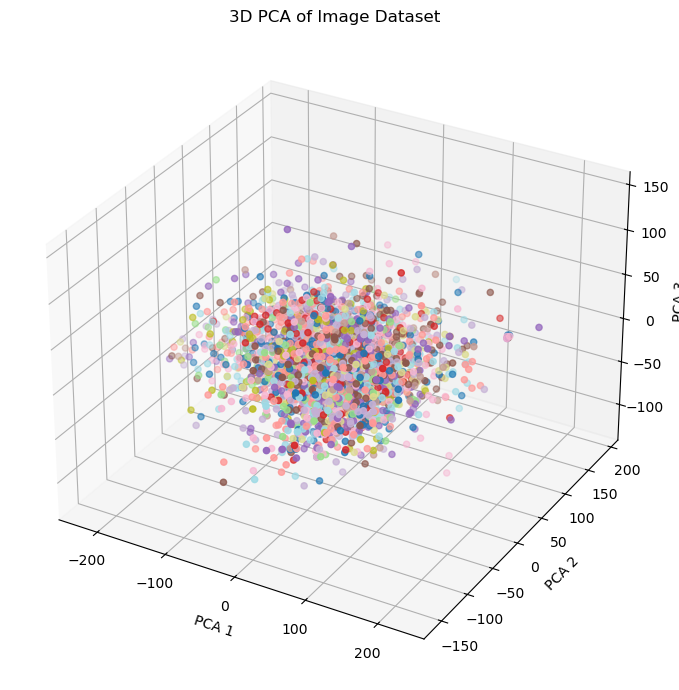

In [29]:
apply_PCA(data_frames[0])

## Training and evaluating models

In [49]:
X_train, X_validation, X_test = tuple(np.stack(data_frame["image"].values) for data_frame in data_frames)
y_train, y_validation, y_test = tuple(np.stack(data_frame["label"].values) for data_frame in data_frames)


# PCA for dimentionality reduction
X_train_pca, X_validation_pca, X_test_pca = apply_PCA(X_train, y_train), apply_PCA(X_validation, y_validation), apply_PCA(X_test, y_test)

#### SVM

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)

# Step 4: Train SVM
clf = SVC(kernel='linear', C=1.0, gamma='scale')  # you can also try 'linear' kernel
clf.fit(X_train_scaled, y_train)

# Step 5: Evaluate
y_pred = clf.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.06947368421052631
Classification Report:
               precision    recall  f1-score   support

          14       0.06      0.07      0.06       100
          20       0.07      0.06      0.06       100
          71       0.01      0.01      0.01       100
          74       0.14      0.03      0.05       100
          87       0.08      0.02      0.03       100
          92       0.09      0.32      0.14       100
          99       0.00      0.00      0.00       100
         102       0.00      0.00      0.00       100
         103       0.00      0.00      0.00       100
         106       0.05      0.03      0.04       100
         116       0.10      0.08      0.09       100
         121       0.06      0.21      0.09       100
         130       0.50      0.01      0.02       100
         149       0.07      0.26      0.11       100
         151       0.00      0.00      0.00       100
         179       0.06      0.17      0.09       100
         188       0.09    

/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

#### Random Forest

In [54]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.08894736842105264
Classification Report:
               precision    recall  f1-score   support

          14       0.04      0.04      0.04       100
          20       0.05      0.06      0.05       100
          71       0.08      0.07      0.07       100
          74       0.11      0.15      0.13       100
          87       0.08      0.06      0.07       100
          92       0.08      0.13      0.10       100
          99       0.08      0.05      0.06       100
         102       0.18      0.17      0.18       100
         103       0.09      0.07      0.08       100
         106       0.08      0.08      0.08       100
         116       0.12      0.15      0.13       100
         121       0.06      0.07      0.06       100
         130       0.05      0.04      0.05       100
         149       0.10      0.17      0.13       100
         151       0.14      0.08      0.10       100
         179       0.08      0.07      0.07       100
         188       0.10    

#### Resnet - Deep CNN Model

As a general rule, all the pre-processing of above models wont apply. This section will handle pre-processing and fine-tuning for Resnet specifically

In [11]:
import torch.nn as nn
import torch.optim as optim

import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as TF
from PIL import Image

In [12]:
resnet50 = models.resnet50(pretrained=True)

/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ely/miniconda3/envs/jupyter_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
datasets_for_resnet = datasets_filtered

In [14]:
num_classes = 20
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [16]:
label_white_list

array([ 30, 173, 140,  75,  60, 208,  45, 183,   9, 100, 137, 204, 156,
        82,  15, 200, 167,  18, 209,  86])

In [17]:
len(label_white_list)

20

In [18]:
label_map = {old: new for new, old in enumerate(label_white_list)}

In [19]:
label_map

{np.int64(30): 0,
 np.int64(173): 1,
 np.int64(140): 2,
 np.int64(75): 3,
 np.int64(60): 4,
 np.int64(208): 5,
 np.int64(45): 6,
 np.int64(183): 7,
 np.int64(9): 8,
 np.int64(100): 9,
 np.int64(137): 10,
 np.int64(204): 11,
 np.int64(156): 12,
 np.int64(82): 13,
 np.int64(15): 14,
 np.int64(200): 15,
 np.int64(167): 16,
 np.int64(18): 17,
 np.int64(209): 18,
 np.int64(86): 19}

In [20]:
len(label_map)

20

In [21]:
class HFImageDataset(Dataset):
    def __init__(self, hf_dataset, transform=None, label_map = label_map):
        self.dataset = hf_dataset
        self.transform = transform
        self.label_map = label_map
        

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample["image"]
        if isinstance(image, torch.Tensor):
            image = TF.to_pil_image(image)
        if image.mode != "RGB":
            image = image.convert("RGB")
        label = int(sample["label"]) # Remap to 0–19
        label = self.label_map[label]

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.dataset)

In [22]:
train_ds = HFImageDataset(datasets_for_resnet[0].with_format("torch"), transform=transform)
val_ds = HFImageDataset(datasets_for_resnet[1].with_format("torch"), transform=transform)

In [23]:
img, label = train_ds[3]
label

8

In [24]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

In [25]:
print("train_ds type:", type(train_ds))  # should be HFImageDataset
print("Sample:", train_ds[0][0].shape) 

train_ds type: <class '__main__.HFImageDataset'>
Sample: torch.Size([3, 224, 224])


In [26]:


# Training loop
for epoch in range(5):  # Choose your number of epochs
    resnet50.train()
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = resnet50(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} completed.")

cuda


100%|███████████████████████████████████████████| 94/94 [00:21<00:00,  4.44it/s]


Epoch 1 completed.


100%|███████████████████████████████████████████| 94/94 [00:20<00:00,  4.60it/s]


Epoch 2 completed.


100%|███████████████████████████████████████████| 94/94 [00:20<00:00,  4.57it/s]


Epoch 3 completed.


100%|███████████████████████████████████████████| 94/94 [00:20<00:00,  4.54it/s]


Epoch 4 completed.


100%|███████████████████████████████████████████| 94/94 [00:27<00:00,  3.41it/s]

Epoch 5 completed.


In [27]:
train_losses = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
resnet50 = resnet50.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=1e-4)

for epoch in range(5):
    resnet50.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = resnet50(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f}")

cuda


100%|███████████████████████████████████████████| 94/94 [00:37<00:00,  2.49it/s]


Epoch 1 completed. Avg Loss: 0.0875


100%|███████████████████████████████████████████| 94/94 [00:37<00:00,  2.48it/s]


Epoch 2 completed. Avg Loss: 0.1623


100%|███████████████████████████████████████████| 94/94 [00:39<00:00,  2.41it/s]


Epoch 3 completed. Avg Loss: 0.1038


100%|███████████████████████████████████████████| 94/94 [00:38<00:00,  2.44it/s]


Epoch 4 completed. Avg Loss: 0.0551


100%|███████████████████████████████████████████| 94/94 [00:38<00:00,  2.44it/s]

Epoch 5 completed. Avg Loss: 0.0462


In [31]:
def get_image_data(dataset_split, index: int, as_array = True) -> (np.ndarray | Image, int):
    image_sample = dataset_split[index]
    image, label = np.array(image_sample["image"]) if as_array else image_sample["image"], image_sample["label"]

    return image, label
    

TypeError: unsupported operand type(s) for |: 'type' and 'module'

In [16]:
# Convert to numpy arrays for convenience

label_array = np.array(ds['label'])

In [73]:
example = ds[1]
img = example["image"].convert("L")   # a PIL Image object
label = example["label"] # integer 0–210 representing country


In [74]:
img.show()
